# 기본 + 작은영역도 AREA 변수 추가

In [21]:
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
plt.rcParams['font.family'] = 'NanumGothic'
import platform
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
    rc('font', family='AppleGothic')

matplotlib.rcParams['axes.unicode_minus'] = False

In [22]:
import os
path = os.path.dirname(os.getcwd())
path = os.path.dirname(path)
path = os.path.join(path, "Daesamanlap/ProcessedData")
train = pd.read_csv(os.path.join(path,"merged_train.csv"))
test = pd.read_csv(os.path.join(path,"merged_test.csv"))

In [23]:
import warnings
warnings.filterwarnings(action='ignore')

In [24]:
#pd.set_option('display.max_rows', None)

In [25]:
train=train.drop_duplicates(keep='first')
test=test.drop_duplicates(keep='first')

In [26]:
## 1. EDA 및 전처리(baseline: MSE 98)

### 1) 상가비율

tmp = train.groupby(['단지코드','임대건물구분']).count().iloc[:,:1].reset_index()
store = tmp[tmp['임대건물구분']=='상가'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'상가수'})
apt = tmp[tmp['임대건물구분']=='아파트'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'아파트수'})
total = pd.merge(apt,store,on='단지코드',how='left').fillna(0)
total['상가비율'] = total.apply(lambda x : x['상가수']/(x['아파트수']+x['상가수']),axis=1)
train = pd.merge(train,total[['단지코드','상가비율']],on='단지코드',how='left')

tmp = test.groupby(['단지코드','임대건물구분']).count().iloc[:,:1].reset_index()
store = tmp[tmp['임대건물구분']=='상가'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'상가수'})
apt = tmp[tmp['임대건물구분']=='아파트'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'아파트수'})
total = pd.merge(apt,store,on='단지코드',how='left').fillna(0)
total['상가비율'] = total.apply(lambda x : x['상가수']/(x['아파트수']+x['상가수']),axis=1)
test = pd.merge(test,total[['단지코드','상가비율']],on='단지코드',how='left')

### 2) 세대당가능주차면수

train['세대당_가능주차면수'] = train.apply(lambda x : x['단지내주차면수']/x['총세대수'],axis=1)
test['세대당_가능주차면수'] = test.apply(lambda x : x['단지내주차면수']/x['총세대수'],axis=1)

### 3) 공가비율

train['공가비율'] = train.apply(lambda x : x['공가수']/x['총세대수'],axis=1)
test['공가비율'] = test.apply(lambda x : x['공가수']/x['총세대수'],axis=1)

### 4) 대형전용면적

level = 85

train['대형전용면적'] = train['전용면적'].apply(lambda x : 1 if x>level else 0)
test['대형전용면적'] = test['전용면적'].apply(lambda x : 1 if x>level else 0)

### 5) 공급유형
#- 공공임대 5년/10년 $\rightarrow$ 공공임대(단기)

train.loc[train.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'
test.loc[test.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'

#- 1차원으로 합치기

not_unique = ['공급유형','전용면적','임대건물구분','전용면적별세대수','대형전용면적','임대보증금','임대료','자격유형']

train_one = train.drop(not_unique,axis=1).drop_duplicates().reset_index(drop=True)
test_one = test.drop(not_unique,axis=1).drop_duplicates().reset_index(drop=True)

#- 전용면적별세대수 채우기

for i in train['공급유형'].unique():
    train_one[i] = 0
    test_one[i] = 0

sample = pd.DataFrame(train.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']  # 전용면적별세대수
    ind = train_one[train_one['단지코드']==code].index
    train_one.loc[ind,col] = val

sample = pd.DataFrame(test.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']  # 전용면적별세대수
    ind = test_one[test_one['단지코드']==code].index
    test_one.loc[ind,col] = val

### 6) 임대료 임대보증금 : 평균

sample = train.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
train_one=pd.merge(train_one, sample, on="단지코드", how="left")

sample = test.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
test_one=pd.merge(test_one, sample, on="단지코드", how="left")

### 연면적 / 전용면적은 나중에 drop

from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2) # 12345 중에 2가 제일 좋음

sample = train.groupby('단지코드').mean()[['전용면적']].reset_index()
train_one=pd.merge(train_one, sample, on="단지코드", how="left")

sample = test.groupby('단지코드').mean()[['전용면적']].reset_index()
test_one=pd.merge(test_one, sample, on="단지코드", how="left")

train_one["연면적new"]=train_one.연면적
test_one["연면적new"]=test_one.연면적

train_one.loc[(train_one.연면적new<train_one.전용면적), "연면적new"]=np.nan
test_one.loc[(test_one.연면적new<test_one.전용면적), "연면적new"]=np.nan

#train_one.isna().sum() # 63

#test_one.isna().sum() #23

im=train_one[["단지내주차면수", "총세대수", "전용면적", "연면적new"]]
im = pd.DataFrame(imputer.fit_transform(im),
                     columns = im.columns)

train_one["연면적new"]=im["연면적new"]

imp=test_one[["단지내주차면수", "총세대수", "전용면적", "연면적new"]]
imp = pd.DataFrame(imputer.fit_transform(imp),
                     columns = imp.columns)

test_one["연면적new"]=imp["연면적new"]

### 7) 대형전용면적 총개수

sample = pd.DataFrame(train.groupby('단지코드')['대형전용면적'].sum()).reset_index()
train_one = pd.merge(train_one, sample, on="단지코드", how="left")

sample = pd.DataFrame(test.groupby('단지코드')['대형전용면적'].sum()).reset_index()
test_one = pd.merge(test_one, sample, on="단지코드", how="left")

### 8) 변수제거

col = ['단지명','도로명주소','subway_name','임대상가', '전용면적']

train_one = train_one.drop(col,axis=1)
test_one = test_one.drop(col,axis=1)

In [27]:
train_one.describe()

,총세대수,공가수,지하철역,버스정류장,단지내주차면수,등록차량수,연면적,위도,경도,subway_dist,...,영구임대,공공임대(단기),공공임대(분납),장기전세,공공분양,행복주택,임대료,임대보증금,연면적new,대형전용면적
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,...,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,4.140000e+02,4.140000e+02,414.000000,414.000000
mean,724.669082,13.446860,0.142512,3.705314,586.330918,570.103865,3727.244858,127.702738,36.212453,0.261004,...,87.712560,58.374396,2.705314,1.497585,1.717391,40.992754,3.323912e+05,2.464968e+07,4385.644284,0.065217
std,407.805002,10.326431,0.401546,2.826735,363.665625,391.585826,4819.394460,0.845181,1.121667,0.361569,...,308.547573,212.574539,33.729376,21.921691,34.943744,199.703951,1.006223e+06,1.634678e+07,4775.704596,0.275026
min,26.000000,0.000000,0.000000,0.000000,13.000000,13.000000,5.688000,126.266160,33.249796,0.000582,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.700000e+04,8.507588e+05,37.180000,0.000000
25%,450.250000,5.000000,0.000000,2.000000,318.250000,289.250000,214.847500,127.051385,35.243825,0.019123,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.258051e+05,1.497620e+07,816.695000,0.000000
50%,633.500000,13.000000,0.000000,3.000000,517.000000,505.000000,3126.412941,127.444874,36.224465,0.086563,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.687925e+05,2.004767e+07,4121.682000,0.000000
75%,923.500000,20.000000,0.000000,4.000000,785.750000,760.000000,5894.521750,128.504449,37.310355,0.387130,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.345014e+05,2.970952e+07,6138.520000,0.000000
max,2568.000000,55.000000,3.000000,20.000000,1798.000000,2550.000000,53027.300800,129.395858,38.202292,1.890024,...,2385.000000,1444.000000,550.000000,370.000000,711.000000,2200.000000,1.198486e+07,1.330654e+08,53027.300800,2.000000


In [28]:
train_up = train_one[train_one['단지내주차면수']>=987].reset_index(drop=True)
train_down = train_one[train_one['단지내주차면수']<987].reset_index(drop=True)

test_up = test_one[test_one['단지내주차면수']>=987].reset_index(drop=True)
test_down = test_one[test_one['단지내주차면수']<987].reset_index(drop=True)

train_up_new = train_one[train_one['단지내주차면수']>=318].reset_index(drop=True)

# train_up 보충하기

In [29]:
tmp1 = pd.concat([train_one.등록차량수.describe(), train_down.등록차량수.describe(),train_up.등록차량수.describe()],axis=1)
tmp1.columns = ["tr","tr_dwn","tr_up"]
tmp1

,tr,tr_dwn,tr_up
count,414.000000,362.000000,52.000000
mean,570.103865,476.930939,1218.730769
std,391.585826,278.952588,447.614072
min,13.000000,13.000000,196.000000
25%,289.250000,266.000000,913.000000
50%,505.000000,448.500000,1149.000000
75%,760.000000,648.750000,1408.250000
max,2550.000000,1653.000000,2550.000000


In [30]:
tmp = pd.concat([train_one.단지내주차면수.describe(), train_down.단지내주차면수.describe(),train_up.단지내주차면수.describe(),test.단지내주차면수.describe(),test_down.단지내주차면수.describe(),test_up.단지내주차면수.describe()],axis=1)
tmp.columns = ["tr","tr_dwn","tr_up","tst","tst_dwn","tst_up"]
tmp

,tr,tr_dwn,tr_up,tst,tst_dwn,tst_up
count,414.000000,362.000000,52.000000,936.000000,128.000000,19.000000
mean,586.330918,485.129834,1290.846154,565.121795,467.585938,1170.105263
std,363.665625,247.650963,241.019842,343.226001,225.105033,157.129775
min,13.000000,13.000000,988.000000,29.000000,29.000000,989.000000
25%,318.250000,287.250000,1103.750000,308.000000,280.750000,1075.000000
50%,517.000000,451.500000,1201.500000,491.000000,449.500000,1141.000000
75%,785.750000,670.250000,1494.750000,771.000000,632.250000,1219.000000
max,1798.000000,986.000000,1798.000000,1696.000000,980.000000,1696.000000


In [31]:
tmp = pd.concat([train_one.총세대수.describe(), train_down.총세대수.describe(),train_up.총세대수.describe(),test.총세대수.describe(),test_down.총세대수.describe(),test_up.총세대수.describe()],axis=1)
tmp.columns = ["tr","tr_dwn","tr_up","tst","tst_dwn","tst_up"]
tmp

,tr,tr_dwn,tr_up,tst,tst_dwn,tst_up
count,414.000000,362.000000,52.000000,936.000000,128.000000,19.000000
mean,724.669082,634.734807,1350.750000,825.050214,607.328125,1283.421053
std,407.805002,326.730995,366.095127,498.276935,326.956259,221.504030
min,26.000000,26.000000,742.000000,75.000000,75.000000,963.000000
25%,450.250000,409.250000,1103.500000,480.000000,384.500000,1161.000000
50%,633.500000,581.000000,1323.500000,708.000000,551.000000,1297.000000
75%,923.500000,817.500000,1515.000000,1060.000000,772.250000,1369.500000
max,2568.000000,2428.000000,2568.000000,2572.000000,2572.000000,1974.000000


In [32]:
tmp_tr = train_one[["단지코드","총세대수","단지내주차면수","등록차량수"]]
tmp_tr_up = train_up[["단지코드","총세대수","단지내주차면수","등록차량수"]]
tmp_tr_dwn = train_down[["단지코드","총세대수","단지내주차면수","등록차량수"]]


In [33]:
tmp_tr["총세-등차"] = tmp_tr["총세대수"]-tmp_tr["등록차량수"]
tmp_tr["단주-등차"] = tmp_tr["단지내주차면수"]-tmp_tr["등록차량수"]

tmp_tr_up["총세-등차"] = tmp_tr_up["총세대수"]-tmp_tr_up["등록차량수"]
tmp_tr_up["단주-등차"] = tmp_tr_up["단지내주차면수"]-tmp_tr_up["등록차량수"]

tmp_tr_dwn["총세-등차"] = tmp_tr_dwn["총세대수"]-tmp_tr_dwn["등록차량수"]
tmp_tr_dwn["단주-등차"] = tmp_tr_dwn["단지내주차면수"]-tmp_tr_dwn["등록차량수"]


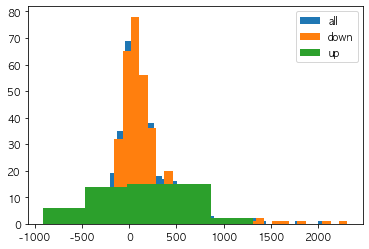

In [34]:
plt.hist(tmp_tr["총세-등차"],bins = int(len(tmp_tr)/10))
plt.hist(tmp_tr_dwn["총세-등차"],bins = int(len(tmp_tr_dwn)/10))
plt.hist(tmp_tr_up["총세-등차"],bins = int(len(tmp_tr_up)/10))
plt.legend(("all","down","up"))
plt.show()

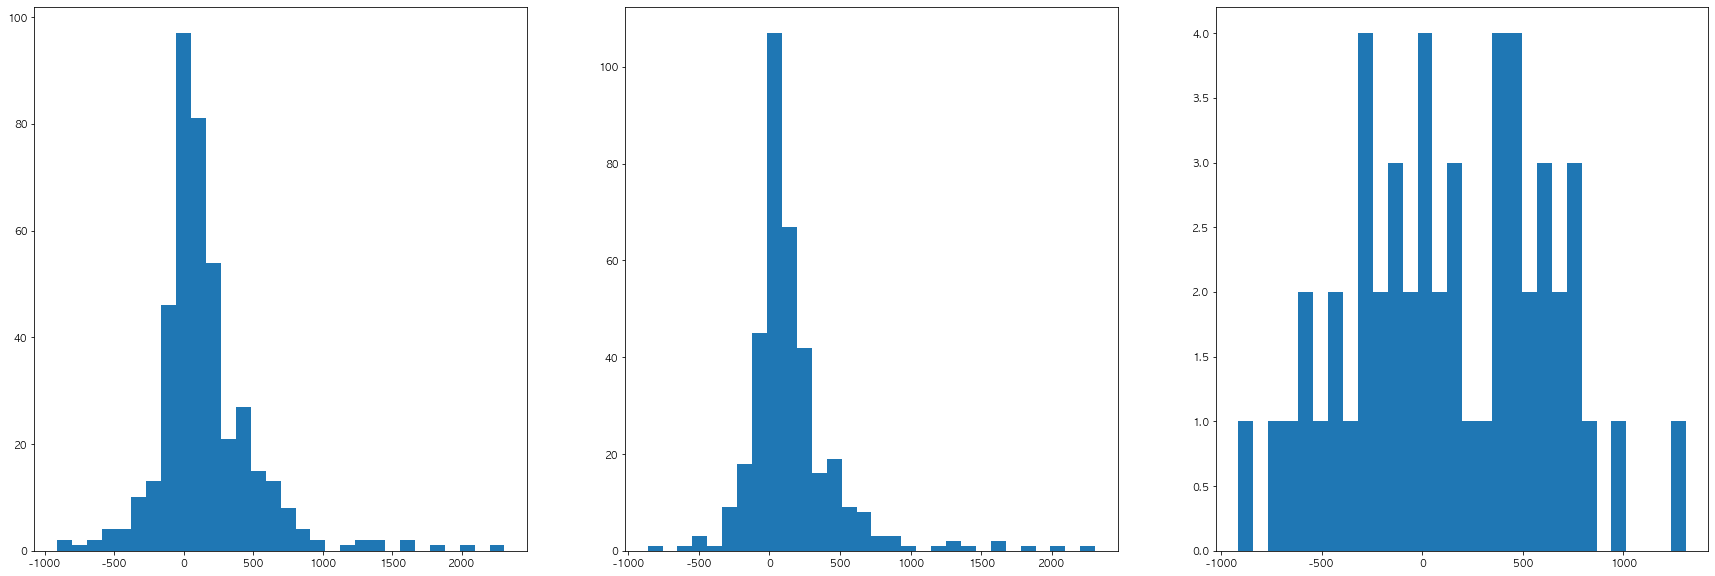

In [35]:
plt.subplots(figsize=(30,10))
plt.subplot(1,3,1)
plt.hist(tmp_tr["총세-등차"],bins =30)
plt.subplot(1,3,2)
plt.hist(tmp_tr_dwn["총세-등차"],bins =30)
plt.subplot(1,3,3)
plt.hist(tmp_tr_up["총세-등차"],bins =30)
plt.show()

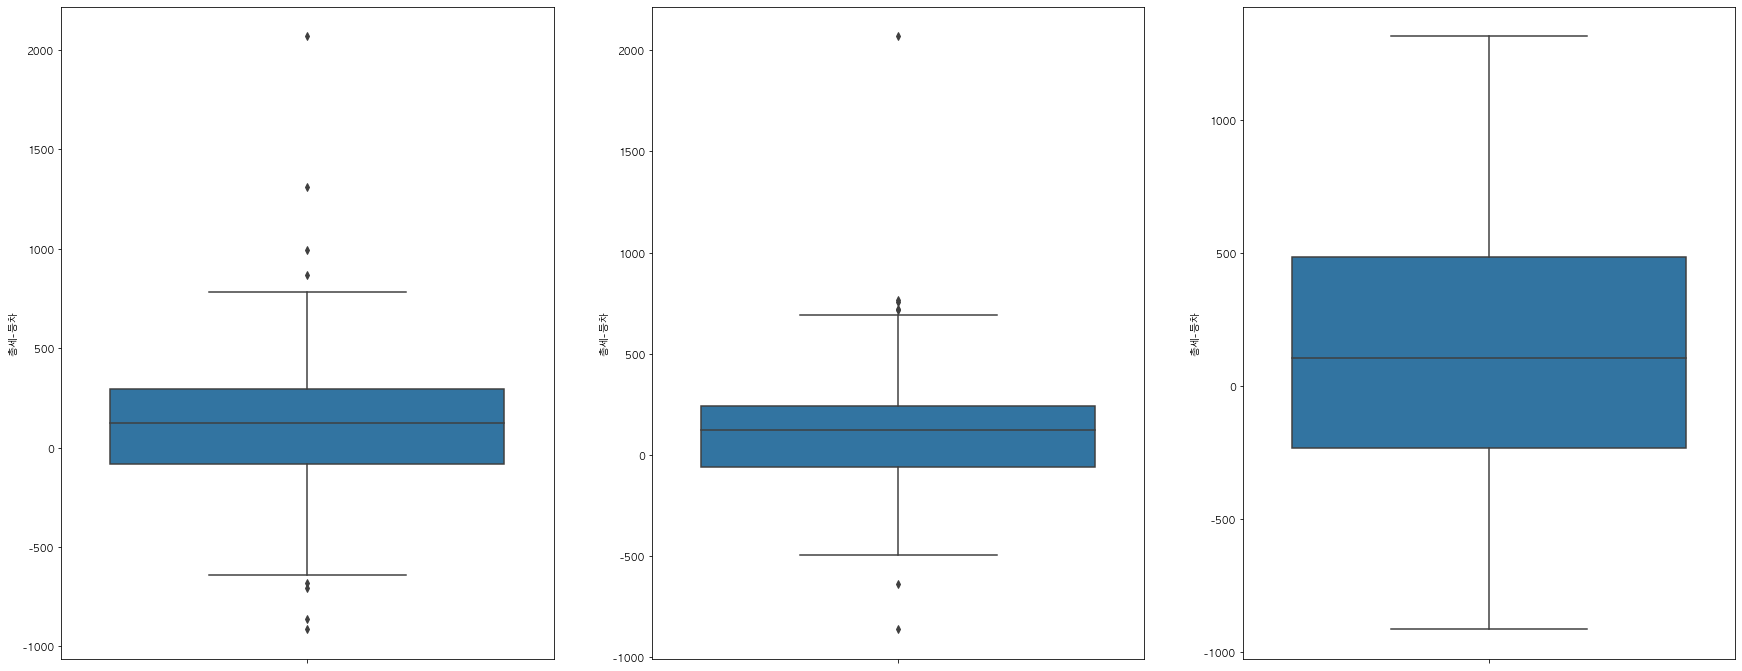

In [36]:
plt.subplots(figsize=(30,12))
plt.subplot(1,3,1)
sns.boxplot(y = tmp_tr["총세-등차"][tmp_tr.단지내주차면수>517])
plt.subplot(1,3,2)
sns.boxplot(y = tmp_tr_dwn["총세-등차"][tmp_tr_dwn.단지내주차면수>517])
plt.subplot(1,3,3)
sns.boxplot(y = tmp_tr_up["총세-등차"][tmp_tr_up.단지내주차면수>517])
plt.show()

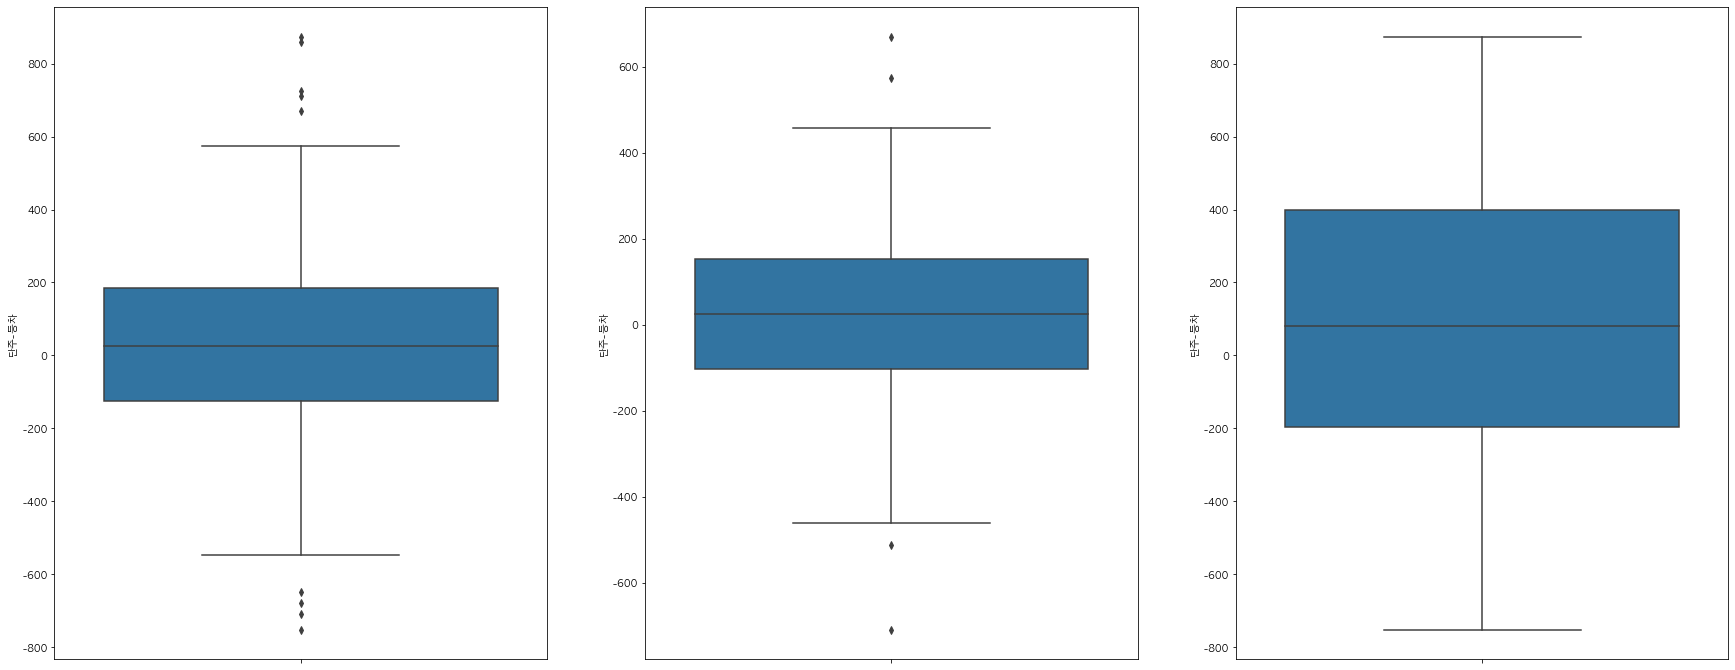

In [37]:
plt.subplots(figsize=(30,12))
plt.subplot(1,3,1)
sns.boxplot(y = tmp_tr["단주-등차"][tmp_tr.단지내주차면수>517])
plt.subplot(1,3,2)
sns.boxplot(y = tmp_tr_dwn["단주-등차"][tmp_tr_dwn.단지내주차면수>517])
plt.subplot(1,3,3)
sns.boxplot(y = tmp_tr_up["단주-등차"][tmp_tr_up.단지내주차면수>517])
plt.show()

# ##############

In [48]:
train_one.columns

Index(['단지코드', '총세대수', '지역', '공가수', '지하철역', '버스정류장', '단지내주차면수', '등록차량수', '연면적',
       '위도', '경도', 'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율',
       '남/여_0~19세', '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율',
       '20~39세_비율', '40~69세_비율', '70세이상_비율', '상가비율', '세대당_가능주차면수', '공가비율',
       '국민임대', '공공임대(50년)', '영구임대', '공공임대(단기)', '공공임대(분납)', '장기전세', '공공분양',
       '행복주택', '임대료', '임대보증금', '연면적new', '대형전용면적'],
      dtype='object')

## 2. 데이터 나누기: 단지내주차면수 987 기준

### 1) train/test up : area 변수 추가(Baseline추가 MSE:96)

In [38]:
def areafunc(x):
    if x in ['제주특별자치도','경상남도','부산광역시']:
        return 0
    elif x in ['광주광역시','세종특별자치시','경상북도','전라북도','서울특별시']:
        return 1
    elif x in ['대구광역시']:
        return 2
    else: 
        return 3

In [39]:
train_up['지역'] = train_up['지역'].apply(lambda x : areafunc(x))
test_up['지역'] = test_up['지역'].apply(lambda x : areafunc(x))

In [40]:
train_up = train_up.join(pd.get_dummies(train_up['지역'],prefix='area')).iloc[:,:-1]
test_up = test_up.join(pd.get_dummies(test_up['지역'],prefix='area')).iloc[:,:-1]

In [41]:
train_up_new['지역'] = train_up_new['지역'].apply(lambda x : areafunc(x))
train_up_new = train_up_new.join(pd.get_dummies(train_up_new['지역'],prefix='area')).iloc[:,:-1]

In [ ]:
#test[test.단지코드=="C1692"]

In [ ]:
#test[test.단지코드=="C2267"]

In [ ]:
#X_cor = train_up.select_dtypes(include="number")
#plt.subplots(figsize=(20,15))
#sns.heatmap(X_cor.corr(), cbar = True, annot = True, fmt = '.2f', square = True, cmap = 'Blues', linewidths=.5)

In [ ]:
#ig, axes = plt.subplots(8,5, figsize= (16,32))
#i = 0
#for f in col:
#    c = i % 5
#    r = i // 5   
#    axes[r,c].hist(x = f, bins =30, data = train_up)
#    plt.xlabel(f)
#    i += 1
#plt.show()

In [ ]:
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import RobustScaler
#robustScaler = RobustScaler()
#standardScaler = StandardScaler()
#minMaxScaler = MinMaxScaler()

In [ ]:
#train_up.select_dtypes(include="number")

In [ ]:
#scaler = robustScaler
#loc_f = ['총세대수', '공가수', '연면적' , "임대료", "임대보증금"]
#train_up.loc[:, loc_f] = scaler.fit_transform(train_up[loc_f])
#test_up.loc[:, loc_f] = scaler.transform(test_up[loc_f])

## 3. 모델링

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor

In [16]:
def fit(X_train, X_test, y_train, y_test, model):
    try:
        model.fit(X_train, y_train, verbose=False)
    except:
        model.fit(X_train, y_train)
    tst_pred = model.predict(X_test)
    error = mean_absolute_error(y_test,tst_pred)
    return model, tst_pred, error


def fit_models(X, y, models, cv=False):
    X = np.array(X.reset_index(drop=True))
    y = np.array(y.reset_index(drop=True))
    best_error = 10000
    best_tst_pred = 0
    best_model = ""
    if cv==False:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True,random_state=2021)
        for m in models:
            model, tst_pred, error = fit(X_train, X_test, y_train, y_test, m)
            if best_error > error:
                best_error = error
                best_tst_pred = tst_pred
                best_model = model
    else:
        best_tst_idx = []
        kf = KFold(n_splits = 5, shuffle=True,random_state = 2021)
        for m in models:
            mae = []
            pred= []
            tst_idx = []
            for train_index, test_index in kf.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                model, tst_pred, error = fit(X_train, X_test, y_train, y_test, m)
                mae.append(error)
                pred.append(tst_pred.tolist())
                tst_idx.append(test_index.tolist())
            cv_error = np.mean(mae)
            if best_error > cv_error:
                best_error = cv_error
                best_tst_pred = pred
                best_tst_idx = sum(tst_idx, [])
                best_model = model
    best_tst_pred = sum(best_tst_pred,[])
    best_tst_pred = dict(zip(best_tst_idx,best_tst_pred))
    try:
        best_model = best_model.fit(np.concatenate((X_train, X_test),axis=0), 
                                                np.concatenate((y_train, y_test),axis=0), 
                                                verbose=False)
    except:
        best_model = best_model.fit(np.concatenate((X_train, X_test),axis=0), 
                                        np.concatenate((y_train, y_test),axis=0))
    return best_model, best_tst_pred, best_error

### 1) train/test down

In [17]:
X = train_down.drop(columns=['단지코드','등록차량수', "연면적new"],axis=1)
X = pd.get_dummies(X, drop_first=True) 
y = train_down['등록차량수']

In [18]:
models = [CatBoostRegressor(random_state=2021, loss_function = 'MAE')]
model_down,pred_down,error_down = fit_models(X, y, models, cv=True)
print('MAE : ',error_down)

MAE :  105.64508272123896


<AxesSubplot:>

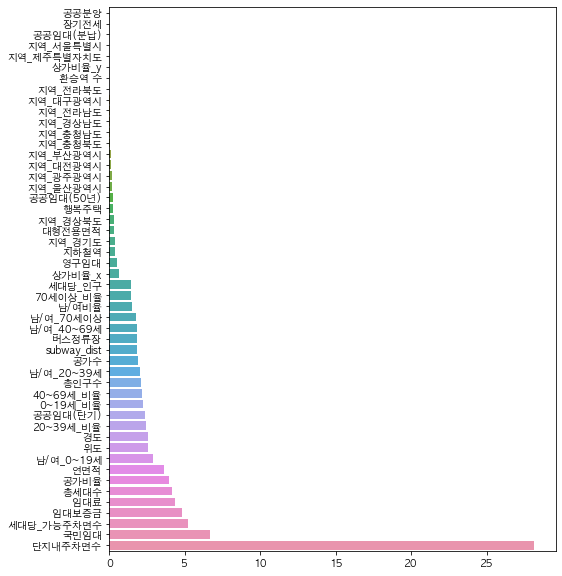

In [19]:
plt.figure(figsize=(8,10))
sns.barplot(y = X.columns[np.argsort(model_down.feature_importances_)], x = list(model_down.feature_importances_[np.argsort(model_down.feature_importances_)]))

In [ ]:
best_tst_pred0 = pred_up
col = ["단지코드","단지내주차면수","총세대수","세대당_가능주차면수","상가비율","연면적","공가수","공가비율","임대보증금"]
tst_pred0 = pd.merge(pd.DataFrame(best_tst_pred0,index=[0]).T.reset_index(),
         pd.DataFrame(train_up[col].reset_index(drop=True)).reset_index(),
         on="index")

tst_pred0 =pd.merge(tst_pred0,train_up[["등록차량수","단지코드"]], on = "단지코드", how = "inner")
tmp0 = tst_pred0[["등록차량수",0]]
# tmp0 = pd.concat([tmp0,tst_pred0[[0]]],axis=1)
tmp0.columns = ["등차","ans"]
tmp0 = tmp0.sort_values("등차")
plt.figure(figsize=(16,12))
sns.lineplot(x =range(len(tmp0)),y = tmp0.등차)
sns.lineplot(x =range(len(tmp0)),y = tmp0.ans)
plt.legend(("answer","anss"))
plt.show()

In [182]:
best_tst_pred0 = pred_down
col = ["단지코드","단지내주차면수","총세대수","세대당_가능주차면수","상가비율","연면적","공가수","공가비율","임대보증금"]
tst_pred0 = pd.merge(pd.DataFrame(best_tst_pred0,index=[0]).T.reset_index(),
         pd.DataFrame(train_down[col].reset_index(drop=True)).reset_index(),
         on="index")

tst_pred0 =pd.merge(tst_pred0,train_down[["등록차량수","단지코드"]], on = "단지코드", how = "inner")
mean_absolute_error(tst_pred0["등록차량수"], tst_pred0[0])

105.38656811692839

In [185]:
tmp0 = tst_pred0[["등록차량수",0]]
# tmp0 = pd.concat([tmp0,tst_pred0[[0]]],axis=1)
tmp0.columns = ["등차","ans"]
tmp0 = tmp0.sort_values("등차")
tmp0

,등차,ans
286,13.0,169.307086
217,16.0,122.015165
82,19.0,166.736749
145,19.0,115.649703
264,22.0,85.956524
...,...,...
235,1162.0,814.755695
204,1200.0,915.427415
125,1240.0,723.482904
211,1359.0,861.309829


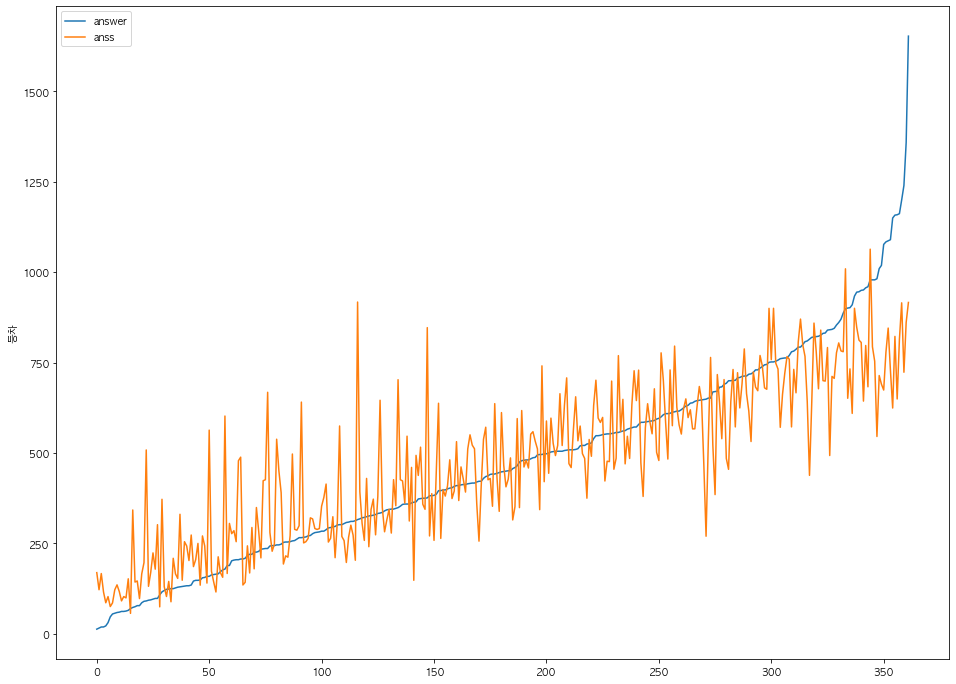

In [187]:
plt.figure(figsize=(16,12))
sns.lineplot(x =range(len(tmp0)),y = tmp0.등차)
sns.lineplot(x =range(len(tmp0)),y = tmp0.ans)
plt.legend(("answer","anss"))
plt.show()

### 2) train/test up

In [151]:
#train_up_new = train_one[train_one['단지내주차면수']>=785].reset_index(drop=True)
# train_down = train_one[train_one['단지내주차면수']<987].reset_index(drop=True)

#test_up = test_one[test_one['단지내주차면수']>=987].reset_index(drop=True)
# test_down = test_one[test_one['단지내주차면수']<987].reset_index(drop=True)

In [52]:
X = train_up.drop(columns=['단지코드','등록차량수','지역','상가비율', "연면적"],axis=1)
X = X[['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수',  '연면적new','위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금', '대형전용면적', 'area_0', 'area_1', 'area_2']]
y = train_up['등록차량수']

models = [CatBoostRegressor(random_state=2021, loss_function = 'MAE')]
model_up,pred_up,error_up = fit_models(X, y, models, cv=True)
print('MAE : ',error_up)

MAE :  291.87954235273975


In [196]:
X = train_up.drop(columns=['단지코드','등록차량수','지역','상가비율', "연면적"],axis=1)
X = X[['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수',  '연면적new','위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금', '대형전용면적', 'area_0', 'area_1', 'area_2']]
y = train_up['등록차량수']
import time
start = time.time()

param_grid = {'grow_policy':["LossGuide","SymmetricTree","Depthwise"],
 'depth': [3,4,5,6, None],
 'learning_rate': [0.01,0.05,0.1,0.3],
 "iterations": [200,  600, 1000, 1600,  2000],
 "eval_metric":["RMSE","MAE","Quantile","Poisson"],
 "l2_leaf_reg":[1,2,4],
  "bagging_temperature"   :[0,0.5,1],
  "min_child_samples":[1,2,4]}
             
cb = CatBoostRegressor(random_state = 2021)
cb_random = RandomizedSearchCV(estimator = cb, param_distributions = param_grid, n_iter = 1000, cv = 5, verbose=2, random_state=42, n_jobs = -1)
cb_random.fit(X, y)
cb_random.best_params_

bp0 = cb_random.best_params_
print(bp0)

print(time.time()-start)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:   53.9s
[Parallel(n_jobs=-1)]: Done 696 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1061 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1522 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 2065 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 2704 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 3393 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 4162 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed: 14.4min finished


0:	learn: 304.1060151	total: 3.12ms	remaining: 1.87s
1:	learn: 268.9517242	total: 4.73ms	remaining: 1.42s
2:	learn: 231.5534120	total: 5.7ms	remaining: 1.13s
3:	learn: 214.2519858	total: 6.39ms	remaining: 952ms
4:	learn: 199.3933449	total: 6.99ms	remaining: 832ms
5:	learn: 173.6606225	total: 7.87ms	remaining: 779ms
6:	learn: 155.8432210	total: 8.57ms	remaining: 726ms
7:	learn: 147.4230333	total: 9.04ms	remaining: 669ms
8:	learn: 131.8953041	total: 9.51ms	remaining: 625ms
9:	learn: 120.6644040	total: 9.97ms	remaining: 588ms
10:	learn: 111.2537638	total: 10.5ms	remaining: 563ms
11:	learn: 104.3876956	total: 11ms	remaining: 541ms
12:	learn: 95.9343129	total: 11.6ms	remaining: 524ms
13:	learn: 91.0404094	total: 12.1ms	remaining: 508ms
14:	learn: 84.3068082	total: 12.7ms	remaining: 495ms
15:	learn: 76.4833593	total: 13.1ms	remaining: 480ms
16:	learn: 71.0309566	total: 13.6ms	remaining: 467ms
17:	learn: 64.5093305	total: 14.1ms	remaining: 457ms
18:	learn: 60.9694831	total: 15ms	remaining: 45

305:	learn: 0.0000000	total: 180ms	remaining: 173ms
306:	learn: 0.0000000	total: 181ms	remaining: 173ms
307:	learn: 0.0000000	total: 182ms	remaining: 172ms
308:	learn: 0.0000000	total: 182ms	remaining: 172ms
309:	learn: 0.0000000	total: 183ms	remaining: 171ms
310:	learn: 0.0000000	total: 183ms	remaining: 170ms
311:	learn: 0.0000000	total: 184ms	remaining: 170ms
312:	learn: 0.0000000	total: 185ms	remaining: 170ms
313:	learn: 0.0000000	total: 186ms	remaining: 169ms
314:	learn: 0.0000000	total: 186ms	remaining: 168ms
315:	learn: 0.0000000	total: 187ms	remaining: 168ms
316:	learn: 0.0000000	total: 187ms	remaining: 167ms
317:	learn: 0.0000000	total: 188ms	remaining: 166ms
318:	learn: 0.0000000	total: 188ms	remaining: 166ms
319:	learn: 0.0000000	total: 189ms	remaining: 165ms
320:	learn: 0.0000000	total: 189ms	remaining: 165ms
321:	learn: 0.0000000	total: 190ms	remaining: 164ms
322:	learn: 0.0000000	total: 191ms	remaining: 163ms
323:	learn: 0.0000000	total: 191ms	remaining: 163ms
324:	learn: 

bp0 = {'min_child_samples':2, 
 'learning_rate':0.1, 
 'l2_leaf_reg':2, 
 'iterations':600, 
 'grow_policy':"Depthwise", 
 "eval_metric":"Poisson", 
 "depth":5, 
 "bagging_temperature":1}

In [202]:
models = [
     CatBoostRegressor(random_state = 2021,
                       grow_policy = bp0["grow_policy"],
                       depth = bp0['depth'],
                       learning_rate = bp0["learning_rate"],
                       iterations = bp0["iterations"],
                       eval_metric = bp0["eval_metric"],
                       l2_leaf_reg = bp0["l2_leaf_reg"],
                       bagging_temperature = bp0["bagging_temperature"],
                       min_child_samples = bp0["min_child_samples"]
                      )
]
model_up,pred_up,error_up = fit_models(X, y, models, cv=True)
print('MAE : ',error_up)

MAE :  284.1076442491143


In [43]:
X = train_up_new.drop(columns=['단지코드','등록차량수','지역','상가비율', "연면적"],axis=1)
X = X[['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수',  '연면적new','위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금', '대형전용면적', 'area_0', 'area_1', 'area_2']]
y = train_up_new['등록차량수']

models = [CatBoostRegressor(random_state=2021, loss_function = 'MAE')]
model_up2,pred_up2,error_up2 = fit_models(X, y, models, cv=True)
print('MAE : ',error_up2)

MAE :  152.3887995499939


In [179]:
best_tst_pred3 = pred_up2
col = ["단지코드","단지내주차면수","총세대수","세대당_가능주차면수","상가비율","연면적","공가수","공가비율","임대보증금"]
tst_pred3 = pd.merge(pd.DataFrame(best_tst_pred3,index=[0]).T.reset_index(),
         pd.DataFrame(train_up_new[col].reset_index(drop=True)).reset_index(),
         on="index")
tst_pred3 = tst_pred3[tst_pred3.단지내주차면수>987]
tst_pred3 =pd.merge(tst_pred3,train_up[["등록차량수","단지코드"]], on = "단지코드", how = "inner")
mean_absolute_error(tst_pred3["등록차량수"], tst_pred3[0])

262.5731307983661

In [189]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
X = train_up.drop(columns=['단지코드','등록차량수','지역','상가비율', "연면적"],axis=1)
X = X[['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수',  '연면적new','위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금', '대형전용면적', 'area_0', 'area_1', 'area_2']]
y = train_up['등록차량수']

param_grid = {'bootstrap': [True],
 'max_depth': [ 30, 60,  90, None],
 'max_features': ['auto'],
 'min_samples_leaf': [4,8],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200,  600, 1000, 1600,  2000]}
rf = RandomForestRegressor(random_state = 2021)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, n_iter = 1000, cv = 10, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X, y)
rf_random.best_params_

bp = rf_random.best_params_
bp


Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  3.7min finished


{'n_estimators': 2000,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 30,
 'bootstrap': True}

In [192]:
X = train_up.drop(columns=['단지코드','등록차량수','지역','상가비율', "연면적"],axis=1)
X = X[['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수',  '연면적new','위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금', '대형전용면적', 'area_0', 'area_1', 'area_2']]
y = train_up['등록차량수']

models = [RandomForestRegressor(random_state=2021, 
                                n_estimators = bp["n_estimators"],
                                min_samples_split = bp["min_samples_split"],
                                min_samples_leaf = 2,
                                max_features = bp["max_features"],
                                max_depth = bp["max_depth"],
                                bootstrap = bp["bootstrap"])
         ]
model_up_r,pred_up_r,error_up_r = fit_models(X, y, models, cv=True)
print('MAE : ',error_up_r)

MAE :  314.2597027252721


In [ ]:

bp = {'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 30,
 'bootstrap': True}
rf = RandomForestRegressor(random_state = 42,n_estimators = 200,min_samples_split = bp["min_samples_split"],min_samples_leaf = 2,max_features = bp["max_features"],max_depth = bp["max_depth"],bootstrap = bp["bootstrap"])
rf = rf.fit(X_tr,y)
y_tst_pred = rf.predict(X_tst)

In [53]:
best_tst_pred2 = pred_up
col = ["단지코드","단지내주차면수","총세대수","세대당_가능주차면수","상가비율","연면적","공가수","공가비율","임대보증금"]
tst_pred2 = pd.merge(pd.DataFrame(best_tst_pred2,index=[0]).T.reset_index(),
         pd.DataFrame(train_up[col].reset_index(drop=True)).reset_index(),
         on="index")
tst_pred2 = tst_pred2[tst_pred2.단지내주차면수>987]
tst_pred2 =pd.merge(tst_pred2,train_up[["등록차량수","단지코드"]], on = "단지코드", how = "inner")
mean_absolute_error(tst_pred2["등록차량수"], tst_pred2[0])

291.2010136239315

In [44]:
best_tst_pred3 = pred_up2
col = ["단지코드","단지내주차면수","총세대수","세대당_가능주차면수","상가비율","연면적","공가수","공가비율","임대보증금"]
tst_pred3 = pd.merge(pd.DataFrame(best_tst_pred3,index=[0]).T.reset_index(),
         pd.DataFrame(train_up_new[col].reset_index(drop=True)).reset_index(),
         on="index")
tst_pred3 = tst_pred3[tst_pred3.단지내주차면수>987]
tst_pred3 =pd.merge(tst_pred3,train_up[["등록차량수","단지코드"]], on = "단지코드", how = "inner")
mean_absolute_error(tst_pred3["등록차량수"], tst_pred3[0])

279.476815898366

In [89]:
train_up_new.shape, train_up.shape

((104, 42), (52, 42))

In [55]:
tmp = tst_pred3[["등록차량수",0]]
tmp = pd.concat([tmp,tst_pred3[[0]]],axis=1)
tmp = pd.concat([tmp,tst_pred2[[0]]],axis=1)
tmp.columns = ["등차","before","after","f"]
tmp = tmp.sort_values("등차")
tmp

,등차,before,after,f
6,196.0,696.057197,696.057197,1092.179215
33,579.0,922.116245,922.116245,1079.559319
18,619.0,954.381624,954.381624,1058.455053
42,657.0,925.417960,925.417960,1255.893291
47,713.0,794.238536,794.238536,1090.395831
13,733.0,1008.332935,1008.332935,1027.388468
28,783.0,1023.998932,1023.998932,1316.647305
1,795.0,801.121646,801.121646,1145.549872
40,799.0,1145.376572,1145.376572,932.866819
20,839.0,1205.239623,1205.239623,1166.308320


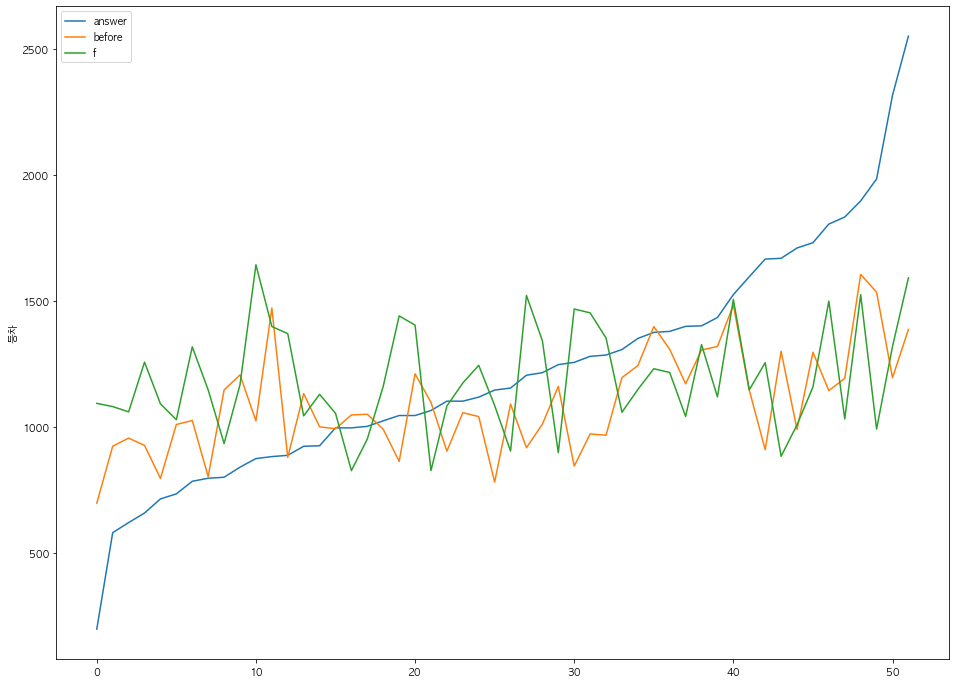

In [57]:
# 25Q 위 데이터 전체 가지고 예측하기 
plt.figure(figsize=(16,12))
sns.lineplot(x =range(len(tmp)),y = tmp.등차)
sns.lineplot(x =range(len(tmp)),y = tmp.before)
sns.lineplot(x =range(len(tmp)),y = tmp.f)
plt.legend(("answer","before","f"))
plt.show()

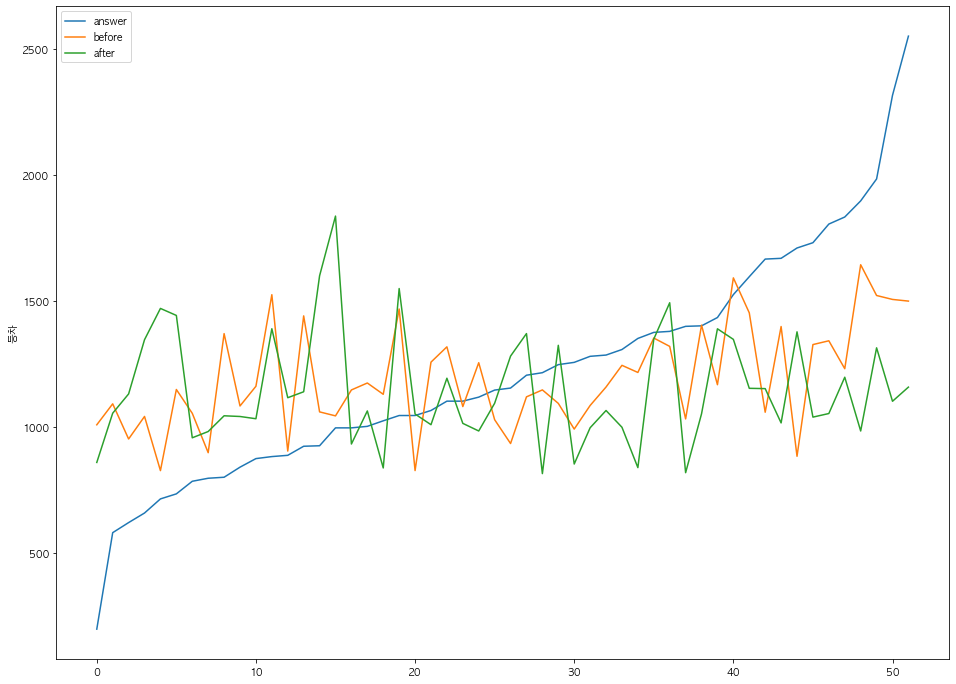

In [181]:
plt.figure(figsize=(16,12))
sns.lineplot(x =range(len(tmp)),y = tmp.등차)
sns.lineplot(x =range(len(tmp)),y = tmp.before)
sns.lineplot(x =range(len(tmp)),y = tmp.after)
plt.legend(("answer","before","after"))
plt.show()

In [ ]:
col = ["단지코드","단지내주차면수","총세대수","세대당_가능주차면수","상가비율","연면적","공가수","공가비율","임대보증금"]
best_tst_pred2 = pred_up
tst_pred2 = pd.merge(pd.DataFrame(best_tst_pred2,index=[0]).T.reset_index(),
         pd.DataFrame(train_up[col].reset_index(drop=True)).reset_index(),
         on="index")
tst_pred2 = pd.merge(tst_pred2, pd.concat([train_up.단지코드,train_up['등록차량수']],axis=1), on = "단지코드")

In [ ]:
col = ["단지코드","단지내주차면수","총세대수","세대당_가능주차면수","상가비율","연면적","공가수","공가비율","임대보증금"]
best_tst_pred2 = pred_up
best_tst_pred4 = pred_up3

tst_pred2 = pd.merge(pd.DataFrame(best_tst_pred2,index=[0]).T.reset_index(),
         pd.DataFrame(train_up[col].reset_index(drop=True)).reset_index(),
         on="index")
tst_pred4 = pd.merge(pd.DataFrame(best_tst_pred3,index=[0]).T.reset_index(),
         pd.DataFrame(train_up_new[col].reset_index(drop=True)).reset_index(),
         on="index")
tst_pred4 = tst_pred4[tst_pred4.단지내주차면수>987]

tst_pred2 = pd.merge(tst_pred2, pd.concat([train_up.단지코드,train_up['등록차량수']],axis=1), on = "단지코드")
tst_pred3 = pd.merge(tst_pred3, pd.concat([train_up_new.단지코드,train_up_new['등록차량수']],axis=1), on = "단지코드")


tst_pred2["diff"] = tst_pred2["등록차량수"]-tst_pred2[0]
tst_pred3["diff"] = tst_pred3["등록차량수"]-tst_pred3[0]


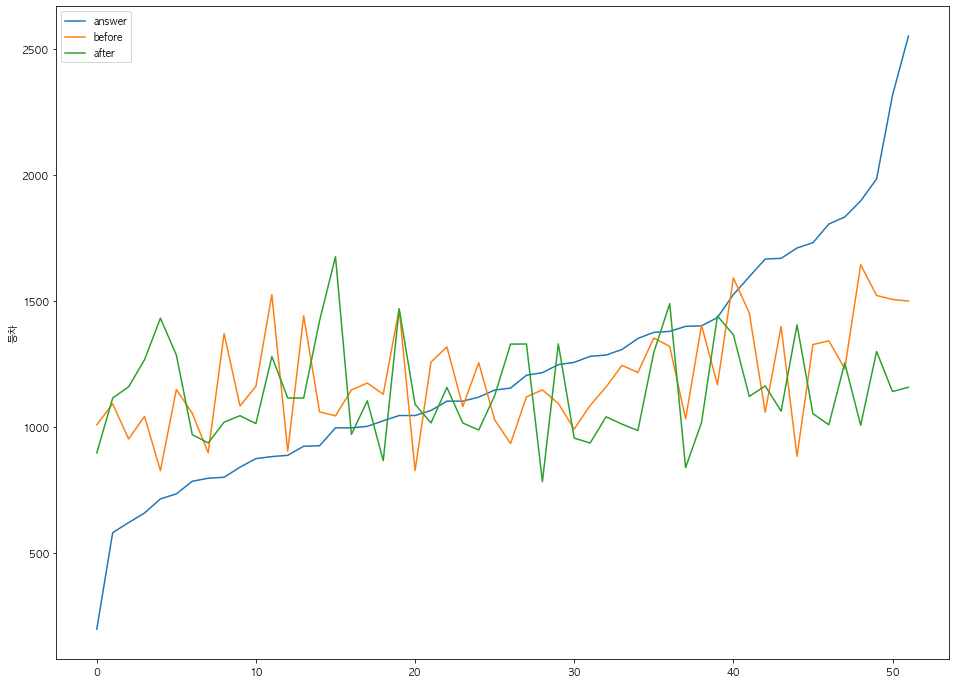

In [121]:

plt.figure(figsize=(16,12))
sns.lineplot(x =range(len(tmp)),y = tmp.등차)
sns.lineplot(x =range(len(tmp)),y = tmp.before)
sns.lineplot(x =range(len(tmp)),y = tmp.after)
plt.legend(("answer","before","after"))
plt.show()

<AxesSubplot:>

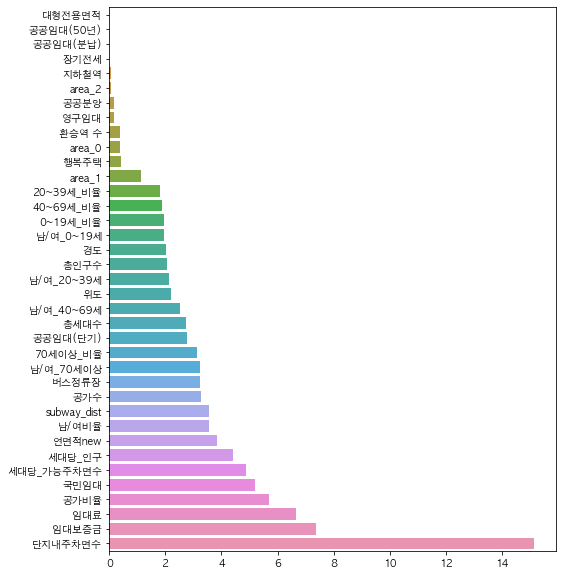

In [90]:
plt.figure(figsize=(8,10))
sns.barplot(y = X.columns[np.argsort(model_up2.feature_importances_)], x = list(model_up2.feature_importances_[np.argsort(model_up2.feature_importances_)]))

<AxesSubplot:>

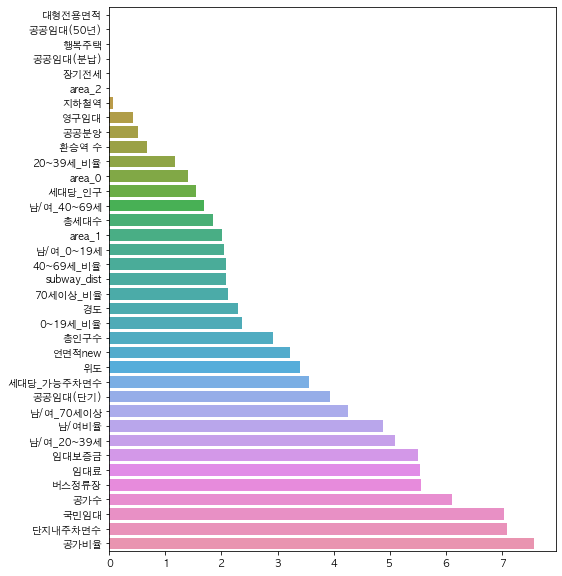

In [87]:
plt.figure(figsize=(8,10))
sns.barplot(y = X.columns[np.argsort(model_up.feature_importances_)], x = list(model_up.feature_importances_[np.argsort(model_up.feature_importances_)]))

In [144]:
df=pd.merge(pd.DataFrame(pred_up,index=[0]).T.reset_index(),
        pd.DataFrame(train_up.단지코드.reset_index(drop=True)).reset_index(),
         on="index")

df=df.drop(columns=["index"])
df.columns=["pred_up", "단지코드"]

In [145]:
df_up=pd.merge(train_one, df, on="단지코드", how='inner')
df_up["diff"]=df_up.등록차량수-df_up.pred_up

In [152]:
#df_up[["단지코드","총세대수","단지내주차면수","등록차량수","pred_up","공가수",
#                       "diff","세대당_가능주차면수"]].sort_values("등록차량수")

In [160]:
#fig, ax = plt.subplots(figsize=(30,5))
#sns.kdeplot(data=df_up,x='등록차량수')
#sns.kdeplot(data=df_up,x='pred_up')

## 4. Final prediction

In [48]:
col = ['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수', '연면적', '위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '상가비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금', '대형전용면적', '지역_경기도', '지역_경상남도', '지역_경상북도', '지역_광주광역시',
       '지역_대구광역시', '지역_대전광역시', '지역_부산광역시', '지역_서울특별시', '지역_세종특별자치시',
       '지역_울산광역시', '지역_전라남도', '지역_전라북도', '지역_제주특별자치도', '지역_충청남도', '지역_충청북도']

In [49]:
X_train = train_down.drop(columns=['단지코드','등록차량수','연면적new'],axis=1)
X_train = pd.get_dummies(X_train, drop_first=True) 
X_train['지역_세종특별자치시'] = 0
X_train = X_train[col]
y_train = train_down['등록차량수']
X_test = test_down.drop(columns=['단지코드'],axis=1)
X_test = pd.get_dummies(X_test, drop_first=True) 
X_test['지역_서울특별시'] = 0
X_test = X_test[col]

In [50]:
cb_down = CatBoostRegressor(random_state=2021,verbose=False).fit(X_train,y_train)
pred_down = cb_down.predict(X_test)

In [51]:
col = ['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수', '연면적new', '위도', '경도',
       'subway_dist', '환승역 수',  '총인구수','세대당_인구','남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금', '대형전용면적', 'area_0', 'area_1', 'area_2']

In [52]:
X_train = train_up.drop(columns=['단지코드','등록차량수','지역', '연면적'],axis=1)
X_train = X_train[col]
y_train = train_up['등록차량수']
X_test = test_up.drop(columns=['단지코드','지역'],axis=1)
X_test = X_test[col]

cb_up = CatBoostRegressor(random_state=2021,
                          verbose=False,
                          loss_function='MAE').fit(X_train,y_train)
pred_up = cb_up.predict(X_test)

In [53]:
def get_pred():
    res_down = pd.DataFrame()
    res_down['code'] = test_down['단지코드'].values
    res_down['num'] = pred_down
    res_up = pd.DataFrame()
    res_up['code'] = test_up['단지코드'].values
    res_up['num'] = pred_up 
    res = pd.concat([res_down,res_up],axis=0).reset_index(drop=True)
    return res_down, res_up, res

In [54]:
#cb_up.get_all_params()

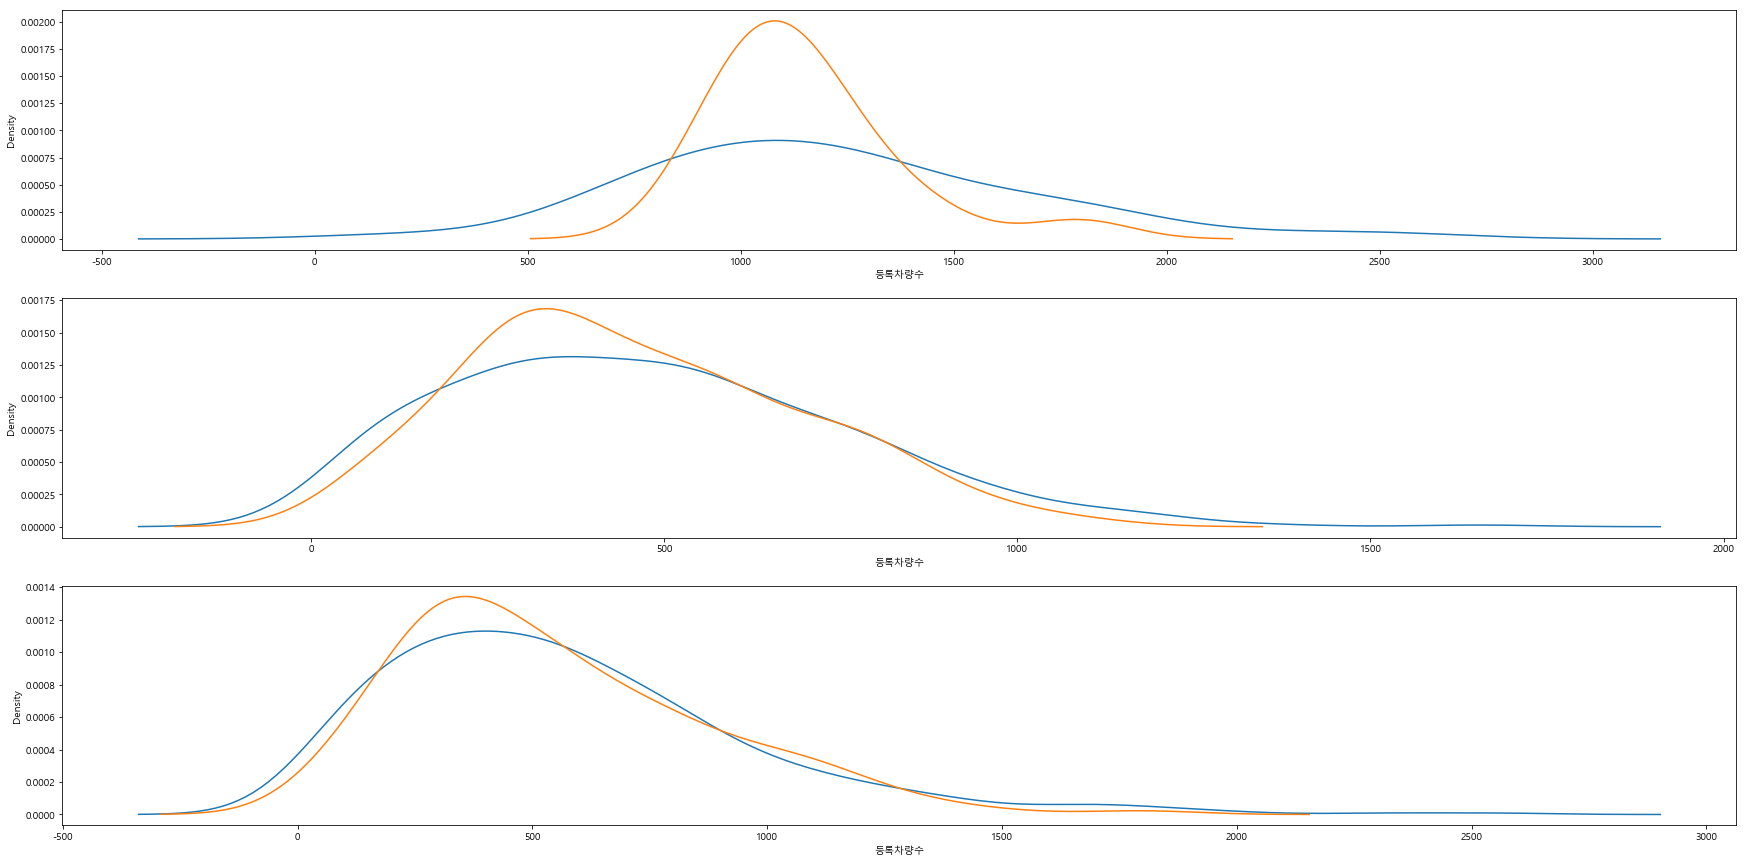

In [55]:
fig, ax = plt.subplots(3,1,figsize=(30,15))
sns.kdeplot(data=train_up,x='등록차량수',ax=ax[0])
sns.kdeplot(data=get_pred()[1],x='num',ax=ax[0])
sns.kdeplot(data=train_down,x='등록차량수',ax=ax[1])
sns.kdeplot(data=get_pred()[0],x='num',ax=ax[1])
sns.kdeplot(data=train_one,x='등록차량수',ax=ax[2])
sns.kdeplot(data=get_pred()[2],x='num',ax=ax[2])

## 5. 기존 score와 비교 및 제출

In [58]:
def submit():
    res = get_pred()[2]
    res.loc[147,:] = ['C1327',0]
    res.loc[148,:] = ['C2335',0]
    res.loc[149,:] = ['C2675',0]
    return res

In [59]:
sub = submit()
sub.to_csv("result/result_area.csv",index=False)

In [56]:
def score(mse):
    score = pd.read_csv("result/MAE_"+str(mse)+".csv")
    score = pd.merge(score,get_pred()[2],on='code',how='inner')
    val = test_up['단지코드'].values
    score_up = score.loc[score['code'].isin(val),:]
    score_down = score.loc[-score['code'].isin(val),:] #y가 새롭게 예측
    mae = mean_absolute_error(score['num_x'],score['num_y'])
    mae_up = mean_absolute_error(score_up['num_x'],score_up['num_y'])
    mae_down = mean_absolute_error(score_down['num_x'],score_down['num_y'])
    print('전체 MAE : ',mae)
    print('큰 영역 MAE : ',mae_up)
    print('작은 영역 MAE : ',mae_down)
    return score

In [57]:
score(96)

전체 MAE :  3.4270497268203535
큰 영역 MAE :  26.514542623294066
작은 영역 MAE :  3.68594044175552e-14


,code,num_x,num_y
0,C1072,751.540951,751.540951
1,C1456,539.409116,539.409116
2,C1840,533.220234,533.220234
3,C1640,464.134797,464.134797
4,C1377,364.187487,364.187487
...,...,...,...
142,C1525,1139.379376,1153.158916
143,C2267,940.641339,980.543625
144,C1692,969.004960,974.003615
145,C1570,899.031182,913.606063


In [ ]:
res2 = score(96)

In [ ]:
res1 = score(98)

In [ ]:
res3 = score(99)

In [ ]:
res4 = score(100)